## PURPOSE OF THIS NOTEBOOK

The goal here is to test code and functions that will be used to automate the finding of key corners. 

In [1]:
import pandas as pd
import numpy as np
import fastf1
import fastf1.plotting
import matplotlib as mpl
import datetime
import timedelta

from KeyCornerFilter import get_statistical_metrics
from scipy import stats
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

## Starting off 
I'm going to start off by doing a 1 lap experiement on testing code that points out which corners are key to analyizing driver braking confidence. Part of this will be filtering and ranking each of the predefined zones and only analyzing the most important zones. 

In [2]:
# Get lap information
race = fastf1.get_session(2025, 4, 'R')
race.load()

req         WARNING 	DEFAULT CACHE ENABLED! (1.75 GB) /home/omah/.cache/fastf1
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 63: Lap timing integrity check failed for 3 lap(s)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16

In [3]:
# Going to evaluate only the fastest lap as an example, will add other drivers soon 
fastest_lap = race.laps.pick_fastest()
car_data = fastest_lap.get_telemetry().add_distance()
lap_tel = car_data.copy()

In [4]:
# Now Calculate the brakezones 
lap_tel['BrakeZone'] = lap_tel[lap_tel['Brake']].index.to_series().diff().ne(1).cumsum()

visualize = lap_tel.copy()
# Drop rows where brake zone is NaN
lap_tel = lap_tel.dropna(subset=['BrakeZone'])

In [5]:
# Now Calculate other features such as Decleration
lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')
# Now Calculate Average Speed at braking
lap_tel['AvgSpeedBraking'] = lap_tel.groupby('BrakeZone')['Speed'].transform('mean')
# Calculate braking times and total laptime in seconds
lap_tel['TotalTime'] = lap_tel['Time'].iloc[-1].total_seconds()
brake_start_dict = {}
brake_end_dict = {}
brake_start_speed_dict = {}
brake_end_speed_dict = {}
for zone, group in lap_tel.groupby('BrakeZone'):
    brake_start_dict[zone] = group['Time'].min().total_seconds()
    brake_end_dict[zone] = group['Time'].max().total_seconds()
    brake_start_speed_dict[zone] = group['Speed'].max()
    brake_end_speed_dict[zone] = group['Speed'].min()

# Map each new value 
lap_tel['SpeedatBrakeStart'] = lap_tel['BrakeZone'].map(brake_start_speed_dict)
lap_tel['SpeedatBrakeEnd'] = lap_tel['BrakeZone'].map(brake_end_speed_dict)
lap_tel['BrakeStartTime'] = lap_tel['BrakeZone'].map(brake_start_dict)
lap_tel['BrakeEndTime'] = lap_tel['BrakeZone'].map(brake_end_dict)
lap_tel['TimeBraking'] = lap_tel['BrakeEndTime'] - lap_tel['BrakeStartTime']

# Convert from kph to m/s
lap_tel['SpeedatBrakeStartMS'] = lap_tel['SpeedatBrakeStart'] * .2778
lap_tel['SpeedatBrakeEndMS'] = lap_tel['SpeedatBrakeEnd'] * .2778

# Calculate Deceleration
lap_tel['Deceleration'] = (lap_tel['SpeedatBrakeStartMS']) / lap_tel['TimeBraking']

/tmp/ipykernel_1216554/2429687791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
/tmp/ipykernel_1216554/2429687791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')
/tmp/ipykernel_1216554/2429687791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

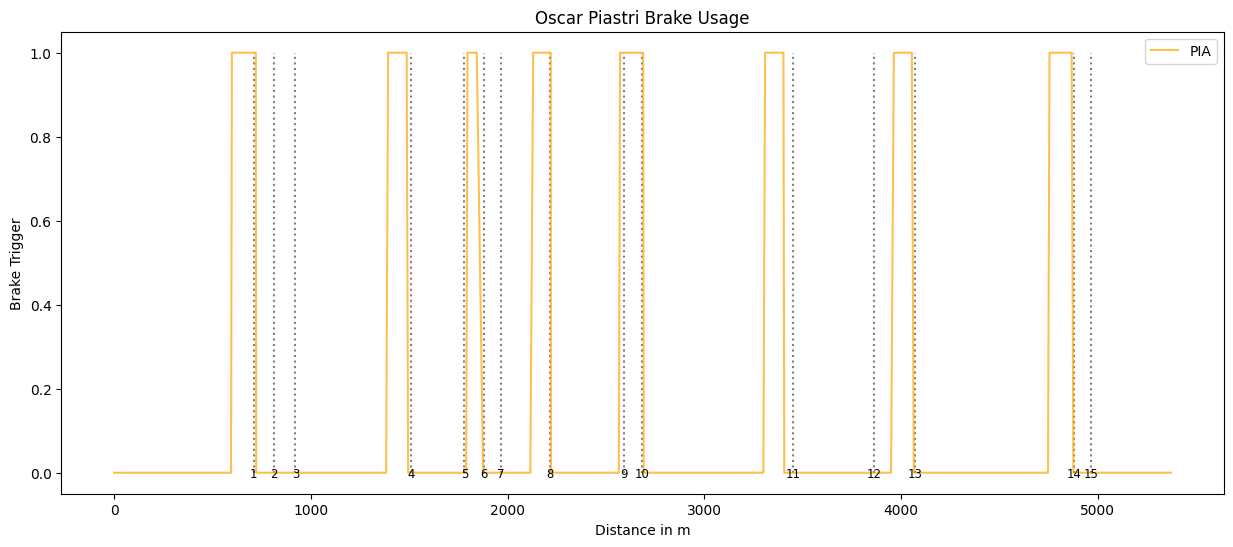

In [17]:
# Visualize key aspects
circuit_info = race.get_circuit_info()

# Plot Binary plot showing braking over distance 
fig, ax = plt.subplots() 

fig.set_figheight(6)
fig.set_figwidth(15)

ax.vlines(x=circuit_info.corners['Distance'], ymin=0, ymax=1, linestyles="dotted", colors='grey')

# Plot corners 
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], 0, txt, 
            va='center_baseline', ha='center', size='small')
    
ax.plot(visualize['Distance'], visualize['Brake'], label ='PIA', color="orange", alpha=0.7)
ax.set_xlabel('Distance in m')
ax.set_ylabel('Brake Trigger')
ax.set_title("Oscar Piastri Brake Usage")
ax.legend()

plt.show()

In [7]:
# Now let's analyze braking zones 
def analyze_braking_zones(lap_tel):
    # Group by zones 
    grouped = lap_tel.groupby('BrakeZone')

    # Calculate summary statistics for deceleration 
    zone_stats = grouped['Deceleration'].agg(['mean', 'max', 'std', 'count'])
    zone_stats['ZoneLength'] = grouped['Distance'].max() - grouped['Distance'].min()
    zone_stats['ZoneStart'] = grouped['Distance'].min() 
    
    return zone_stats

In [8]:
def filter_and_rank_zones(zone_stats, min_zone_length=5, min_mean_deceleration=1, num_zones=3):
    # Filter out short or weak zones 
    filtered_zones = zone_stats[
        (zone_stats['ZoneLength'] > min_zone_length) &
        (zone_stats['mean'] > min_mean_deceleration)
    ].copy()

    # Calculate a braking intestity score
    filtered_zones['BrakingIntensity'] = filtered_zones['mean'] * filtered_zones['ZoneLength']

    # Rank the zones 
    ranked_zones = filtered_zones.sort_values(by='BrakingIntensity', ascending=False)

    top_zones = ranked_zones.head(num_zones)

    return top_zones

In [9]:
zone_stats = analyze_braking_zones(lap_tel).reset_index()
ranked_zones = filter_and_rank_zones(zone_stats).reset_index(drop=True)

In [10]:
ranked_zones

,BrakeZone,mean,max,std,count,ZoneLength,ZoneStart,BrakingIntensity
0,8.0,38.385470,38.385470,0.0,17,112.569431,4754.550899,4321.030542
1,6.0,44.390722,44.390722,0.0,14,93.245801,3308.921533,4139.248401
2,2.0,38.400925,38.400925,0.0,16,94.380194,1392.714021,3624.286737


## Checkpoint
I have now ranked zones based on importance. From my knowledge, these braking zones make sense on why they are considered important. I visualized where braking zones are in relation to corners and know the most important are the turn 4 (braking zone 2), turn 11 (braking zone 6), and turn 14 (braking zone 8). Which is true, these corners are where passing is the most common for drivers as well as the hardest braking zones for Bahrain. Now instead of doing 1 lap, I will do the entire race for Piastri 

In [11]:
# Now get all laps for Oscar
race_laps = race.laps

# Filter to the drivers we want to compare 
PIA_lap = race.laps.pick_drivers('PIA').pick_accurate()

PIA_total_tel = get_statistical_metrics(PIA_lap)

/home/omah/Documents/GitHub/LinkedIn_AIHawk_automatic_job_application/F1Revisited/KeyCornerFilter.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
/home/omah/Documents/GitHub/LinkedIn_AIHawk_automatic_job_application/F1Revisited/KeyCornerFilter.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')
/home/omah/Documents/GitH

In [13]:
zone_stats

,BrakeZone,mean,max,std,count,ZoneLength,ZoneStart
0,1.0,26.010232,26.010232,0.0,25,121.588058,598.591420
1,2.0,38.400925,38.400925,0.0,16,94.380194,1392.714021
2,3.0,74.080000,74.080000,0.0,7,47.031592,1796.313180
3,4.0,24.599761,24.599761,0.0,20,89.242519,2130.047283
4,5.0,21.418307,21.418307,0.0,25,117.573967,2571.650950
5,6.0,44.390722,44.390722,0.0,14,93.245801,3308.921533
6,7.0,38.317241,38.317241,0.0,16,92.042352,3962.810900
7,8.0,38.385470,38.385470,0.0,17,112.569431,4754.550899


In [14]:
zone_stats = analyze_braking_zones(PIA_total_tel).reset_index()
ranked_zones = filter_and_rank_zones(zone_stats).reset_index(drop=True)

In [16]:
ranked_zones

,BrakeZone,mean,max,std,count,ZoneLength,ZoneStart,BrakingIntensity
0,8.0,37.528985,46.456102,4.007772,845,907.595027,3966.465833,34061.120326
1,6.0,38.941819,55.233896,6.014954,810,861.867117,2570.185278,33562.673421
2,7.0,33.965868,55.752249,4.690836,786,766.808437,3302.799167,26045.314518


## Checkpoint
I have converted the code to work with a full race and taking account of all the laps that don't include safety cars or in/out laps. From this, braking zone 2 gets replaced with braking zone 7, which is important but I would argue that 2 is much more important. The next step here is to use this data to generate our confidence score using those brake zones alone. I'm going to also revise the driver confidence measurement to include other factors such as:
1. corner entry speed <-- Calculated with statistics function
2. throttle smoothness <-- Need to calculate
3. brake confidence <-- Calculated with original function, though need to tweak formula some more

I think these three metrics would be cruicial to evaulating a driver's confidence on track. 

In [ ]:
# Start with a function to detect corner entry, key to help calculate corner entry speed
def detect_corner_entry(brake_trigger_signal, distance_values, smoothing_window=3):
    """
    PURPOSE OF THIS FUNCTION:
    Detects corner entry points from a brake trigger signal. 

    Takes in: 
    1. Brake trigger signal (the "brake" column) as a numpy array
    2. Distance value (location of the corner in meters) as a numpy array 
    3. Smoothing window (moving average filter to smooth brake trigger to help reduce noise
       and accurately detect rising edges.)
    """
    # Smoothing 
    smoothed_signal = np.convolve(brake_trigger_signal, np.ones(smoothing_window)/smoothing_window, mode='same')

    # Find where signal changes
    # +1 accounts for the shift when comparing values 
    rising_edges = np.where((smoothed_signal[:1] <.5) & (smoothed_signal[1:] > .5))[0] + 1

    # Get corner entry points
    corner_entry_points = distance_values[rising_edges]

    return corner_entry_points.tolist()


